In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, linalg, optimize, sparse
import statistics
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy.polynomial

In [3]:

def closest(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]
     
def counts_to_irradiance(flame_data, integration_time, k_filepath):
    
    k_data = np.loadtxt(k_filepath,skiprows=1)
    irradiance = np.zeros(flame_data.shape)
    for i in range(len(irradiance[:,0])):
        irradiance[i,0] = flame_data[i,0]
        k_data_closest_index = np.where(k_data[:,0] == closest(k_data[:,0],flame_data[i,0]))[0]
        irradiance[i,1] = flame_data[i,1]*k_data[k_data_closest_index[0],1]/integration_time
        
    return irradiance

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def c_matrix_vertical_derivative (
c_matrix,               #The c_matrix in question
c_matrix_cutwl,         #The cutting wavelength vector of the c_matrix
s_factor=0              #The factor that 
):
    c_matrix_vderivative = np.zeros(c_matrix.shape)
    for j in range(len(c_matrix[0,:])):
        actual_spl_fit = interpolate.UnivariateSpline(c_matrix_cutwl, c_matrix[:,j], s=s_factor)
        c_matrix_vderivative [:,j] = -actual_spl_fit.derivative(n=1)(c_matrix_cutwl)

    return c_matrix_vderivative

LOAD CELL MEASUREMENTS

In [4]:
#We load the measurements:
device_filename = 'Device 0830ThY61 - L'    #Here write the folder name of your device
cell_filename = 'L.02'                      #Here put the folder name of the cell of your device
measures_filepath = os.path.join(os.getcwd(), 'RainbowMeasures', device_filename, 'TXT files', cell_filename)
measures_filepath_list = os.listdir(measures_filepath)
for file in measures_filepath_list:
    if '.txt' in file:
        measures_filepath = os.path.join(measures_filepath, file)
        print(measures_filepath)

measurement_data= np.loadtxt(measures_filepath, skiprows=1)   
measure_divwl = measurement_data[:,0]
measure_Jsc = -0.1*measurement_data[:,2]
measure_Jsc = numpy.polynomial.polynomial.Polynomial.fit(measure_divwl, measure_Jsc, 10)(measure_divwl)

for i in range(len(measure_Jsc)):
    measure_Jsc[i] = measure_Jsc[i]-measure_Jsc[0]


measure_divwl = measurement_data[:,0]
min_cutwl = np.min(measure_divwl)
#min_cutwl = 410
max_cutwl = np.max(measure_divwl)
inc_cutwl = abs(min_cutwl-max_cutwl)/(len(measure_divwl)-1)
print(min_cutwl, max_cutwl)



c:\Users\UX490UA\Documents\GitHub\SOLS-EQE\Numeric method - second try\RainbowMeasures\Device 0830ThY61 - L\TXT files\L.02\MCV.211005.0830ThY61.1Sun_210930..Red Sweep Opening.txt
400.0 810.0


LOAD SPECTRA DATA AND COMPUTE C MATRIX

In [5]:
spectras_folder = '04OctubreCalibrationCutWL' #Name of the folder with the blue and red calibration spectras
txt_filelist_red = os.listdir(os.path.join(os.getcwd(), spectras_folder, 'Red Sweep Opening'))   #Remember to add 0 to the firsts file names!!
txt_filelist_blue = os.listdir(os.path.join(os.getcwd(), spectras_folder, 'Blue Sweep Opening')) #Remember to add 0 to the firsts file names!!
int_time = 0.2*0.001*0.6
k_filepath = 'flame_to_irradiance_calibrationfile.txt'
spectra_data_red = None
spectra_data_blue = None
bg_spectra_red = np.loadtxt(os.path.join(spectras_folder, 'Red Sweep Opening',txt_filelist_red[0]), skiprows=1)
bg_spectra_blue = np.loadtxt(os.path.join(spectras_folder, 'Blue Sweep Opening', txt_filelist_blue[0]), skiprows=1)


for i in range(len(txt_filelist_red)):
    actual_filepath = os.path.join(spectras_folder, 'Red Sweep Opening', txt_filelist_red[i])
    load_spectra = np.loadtxt(actual_filepath, skiprows=1)
    actual_txt_spectra = np.zeros(load_spectra.shape)
    actual_txt_spectra [:,0] = load_spectra[:,0]
    actual_txt_spectra [:,1] = load_spectra[:,1] - 1*bg_spectra_red[:,1]
    actual_irradiance_spectra = counts_to_irradiance(actual_txt_spectra,int_time,k_filepath)
    if i == 0:
        spectra_data_red = actual_irradiance_spectra
    else:
        spectra_data_red = np.dstack((spectra_data_red, actual_irradiance_spectra))

for i in range(len(txt_filelist_blue)):
    load_spectra = np.loadtxt(os.path.join(spectras_folder, 'Blue Sweep Opening',txt_filelist_blue[i]), skiprows=1)
    actual_txt_spectra = np.zeros(load_spectra.shape)
    actual_txt_spectra [:,0] = load_spectra[:,0]
    actual_txt_spectra [:,1] = load_spectra[:,1] - 1*bg_spectra_blue[:,1]
    actual_irradiance_spectra = counts_to_irradiance(actual_txt_spectra,int_time,k_filepath)
    if i == 0:
        spectra_data_blue = actual_irradiance_spectra
    else:
        spectra_data_blue = np.dstack((spectra_data_blue, actual_irradiance_spectra))


In [6]:
motor_divwl_relation_filename = 'Dividing Wavelength To Motor Position Calibration File_October2021.txt'
motor_divwl_relation = np.loadtxt(os.path.join(spectras_folder, motor_divwl_relation_filename), skiprows=1) #Dividing Wavelength To Motor Position Calibration File.txt
bluesweep_divwl_relation = np.zeros(motor_divwl_relation[:,0:2].shape)
bluesweep_divwl_relation[:,0] = motor_divwl_relation[:,0]
bluesweep_divwl_relation[:,1] = motor_divwl_relation[:,1]
redsweep_divwl_relation = np.zeros(bluesweep_divwl_relation.shape)
redsweep_divwl_relation [:,0] = motor_divwl_relation[:,0]
redsweep_divwl_relation [:,1] = motor_divwl_relation[:,2]
calibration_motor_position = np.linspace(0,50,101) #Here we need to define the motor position for each spectra.
#print(calibration_motor_position)

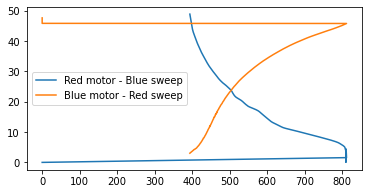

In [7]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(bluesweep_divwl_relation[:,0], bluesweep_divwl_relation[:,1], label ='Red motor - Blue sweep')
ax.plot(redsweep_divwl_relation[:,0], redsweep_divwl_relation[:,1], label ='Blue motor - Red sweep')
plt.legend()



In [8]:
spectra_data = spectra_data_red
cut_wl_relation = redsweep_divwl_relation
print(cut_wl_relation)


[[394.         3.0364  ]
 [394.1        3.046507]
 [394.2        3.056614]
 ...
 [  0.        47.677494]
 [  0.        47.686331]
 [  0.        47.693946]]


(0.0, 10.0)

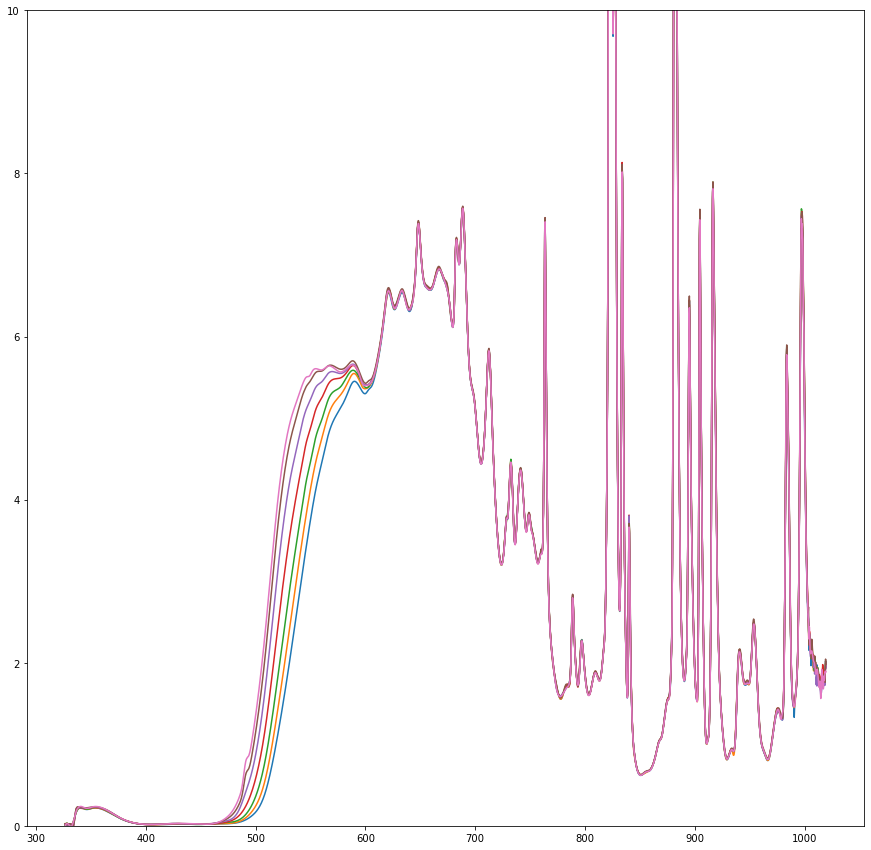

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
for j in range(39,46):
    #ax.plot(spectra_data[:,0,j],spectra_data[:,1,j])
    
    spl=interpolate.UnivariateSpline(spectra_data[:,0,j],spectra_data[:,1,j])
    spl.set_smoothing_factor(2)
    ax.plot(spectra_data[:,0,j], spl(spectra_data[:,0,j]))

plt.ylim(0,10)
#plt.xlim(500,900)

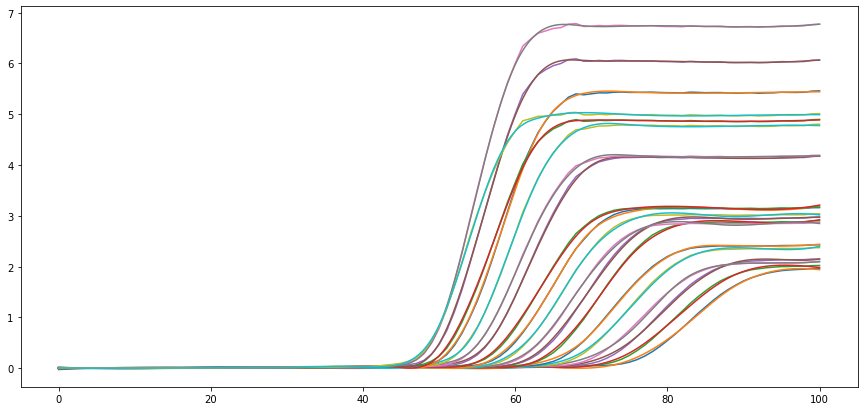

In [180]:

fig, ax = plt.subplots(figsize=(15,7))
for j in range(20,40):
    ax.plot(spectra_data[j*10,1,:])
    
    spl=interpolate.UnivariateSpline(np.linspace(0,100,101),spectra_data[j*10,1,:])
    spl.set_smoothing_factor(0.03)
    ax.plot(np.linspace(0,100,1000), spl(np.linspace(0,100,1000)))
#plt.ylim(4.5,5.5)
#plt.xlim(50,100)
#ax.legend()


In [13]:
#First we define the diferent parmeters of the c_matrix that we want to make. 
c_matrix_min_wl = 380
c_matrix_max_wl = 1000 #round(min(max(measure_divwl[:]), max(spectra_matrix_cutwl))[0])
c_matrix_res_wl = 1
fit_spectra_sfactor = 2
fit_columns_sfactor = 0.003

#Here we construct the calibration_c_matrix wich is the c_matrix with all the calibration spectras (but not corresponding to the cutting wavelengths of the measure, and yet not multiplyed by wavleneght and so on...)
calibration_c_matrix = np.zeros((len(spectra_data[0,0,:]), len(spectra_data[:,0,0])))
calibration_c_matrix_wls = spectra_data[:,0,0]
for j in range(len(calibration_c_matrix[:,0])):
    calibration_c_matrix [j,:] = spectra_data[:,1,j]

#Then, we make a fit with spline of each spectra and save it with the wavelengths parameters (min, max, res) to a matrix called calibration_fit_c_matrix.
c_matrix_wl = np.arange(c_matrix_min_wl, c_matrix_max_wl, c_matrix_res_wl)
calibration_fit_c_matrix = np.zeros((len(calibration_c_matrix[:,0]),len(c_matrix_wl)))
for j in range(len(calibration_c_matrix[:,0])):
    actual_spl = interpolate.UnivariateSpline(calibration_c_matrix_wls,calibration_c_matrix[j,:], s=fit_spectra_sfactor)
    
    for i in range(len(c_matrix_wl)):
        actual_wl = c_matrix_wl[i]
        actual_spectra_average = statistics.mean(actual_spl(np.linspace(actual_wl-(c_matrix_res_wl/2),actual_wl+(c_matrix_res_wl/2), c_matrix_res_wl*10 )))
        calibration_fit_c_matrix[j,i] = 0.01*c_matrix_res_wl*actual_spectra_average/1240*actual_wl


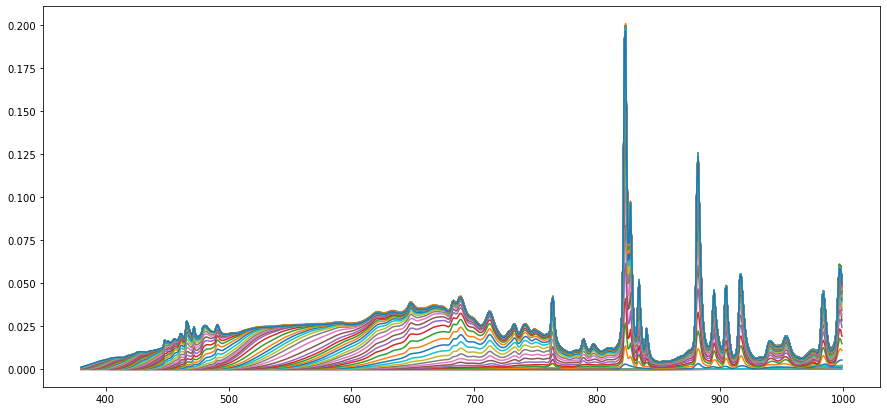

In [14]:
#c_matrix[:,-1:-3] =
fig, ax = plt.subplots(figsize=(15,7))
for j in range(len(calibration_fit_c_matrix[:,0])):
    
    #ax.plot(spectra_matrix_wls, spectra_matrix[j,:], label=str(spectra_matrix_cutwl[j])+str(spectra_matrix_cutwl_ideal[j]))
    ax.plot(c_matrix_wl, calibration_fit_c_matrix[j,:])#, label=str(j))#c_matrix_wl,
    #ax.legend()
#plt.ylim(-0.0008,0.08)
#plt.xlim(390,450)

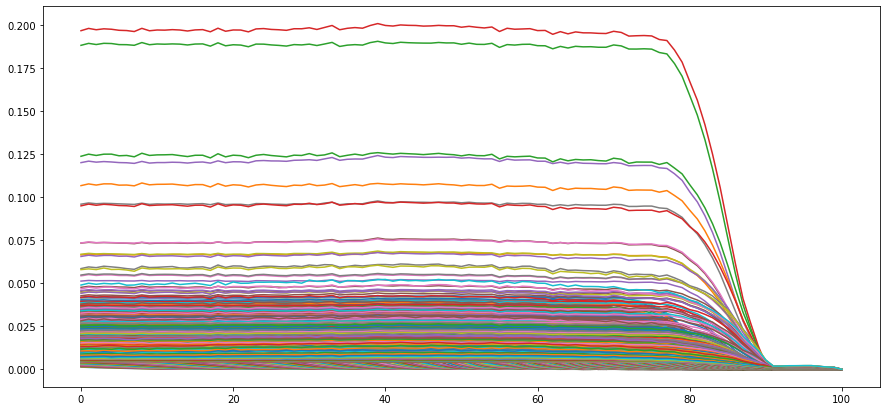

In [25]:
#Here we will finally construct the c_matrix with the wavelengths that has been measured: 
#For that, we first make an spline fit of each row 
#fig, ax = plt.subplots(figsize=(15,7))
fit_columns_sfactor = 0.00005
c_matrix = np.zeros((len(measure_divwl),len(calibration_fit_c_matrix[0,:])))
fig, ax = plt.subplots(figsize=(15,7))
for i in range(len(calibration_fit_c_matrix[0,:])):
    #actual_spl = interpolate.UnivariateSpline(calibration_motor_position,np.flip(calibration_fit_c_matrix[:,i]), s=fit_columns_sfactor) #If RedSweep: np.flip(calibration_fit_c_matrix[:,i]) :)
    actual_spl = interpolate.interp1d(np.flip(calibration_motor_position),calibration_fit_c_matrix[:,i]) #If RedSweep, calibration_motor_position needs a flip :)
    
    ax.plot(actual_spl(calibration_motor_position))
    for j in range(len(measure_divwl)):
        
        actual_index_motorpos = np.where(cut_wl_relation[:,0] == measure_divwl[j])[0]
        #print(cut_wl_relation[actual_index_motorpos,1])
        
        #actual_wl = measure_divwl[j]
        c_matrix[j,i] = actual_spl(cut_wl_relation[actual_index_motorpos,1])

c_matrix_vderivative = c_matrix_vertical_derivative(np.flip(c_matrix, axis=0), np.flip(measure_divwl))
    

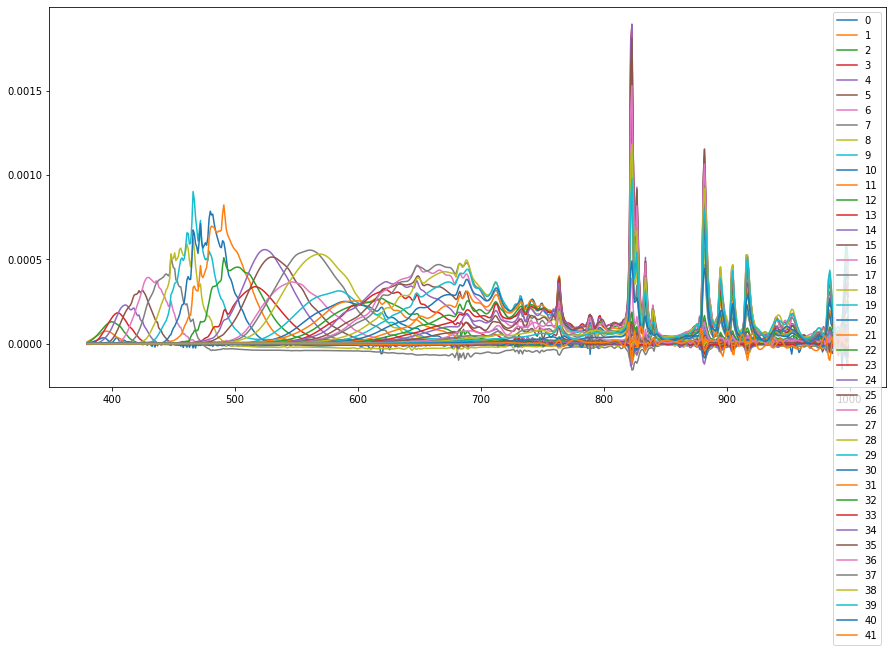

In [26]:
#c_matrix[:,-1:-3] =
fig, ax = plt.subplots(figsize=(15,7))
for j in range(len(c_matrix[:,0])):
    
    #ax.plot(spectra_matrix_wls, spectra_matrix[j,:], label=str(spectra_matrix_cutwl[j])+str(spectra_matrix_cutwl_ideal[j]))
    ax.plot(c_matrix_wl, c_matrix_vderivative[j,:],label=str(j))#, label=str(j))#c_matrix_wl,
    #ax.legend()
plt.legend()
#plt.ylim(-0.0008,0.05)
#plt.xlim(390,450)

     fun: 3317.346454454467
   maxcv: 1.258513532696116e-15
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 10000
  status: 2
 success: False
       x: array([ 6.75374545e+01,  6.79919295e+01,  9.59175268e+01,  8.91968919e+01,
        9.11601585e+01,  9.38203848e+01,  8.71538344e+01,  8.16324435e+01,
        5.76171409e+01,  4.50223343e+01,  2.95529007e+01,  2.01299644e+01,
        6.84649525e+00,  6.95555970e+00,  1.17797193e+01,  1.17180942e+01,
        2.87923650e+00,  2.45468486e+01,  3.06350572e+01,  3.63924321e+01,
        4.31546700e+01,  4.63139720e+01,  5.80895803e+01,  5.79756691e+01,
        4.83860638e+01,  2.86509005e+01,  2.05271129e+01,  1.22721304e-15,
       -3.71444703e-16,  3.02430234e-01, -1.25851353e-15,  1.29133842e-17,
       -9.80276881e-17, -9.92271930e-16,  1.63723031e+00,  1.17213694e-01,
       -1.58375424e-16,  1.06989072e+01,  2.94811939e+00,  2.78074399e+01,
        5.54936299e+01,  5.07916967e+01,  4.73428399e+01,  5.20878

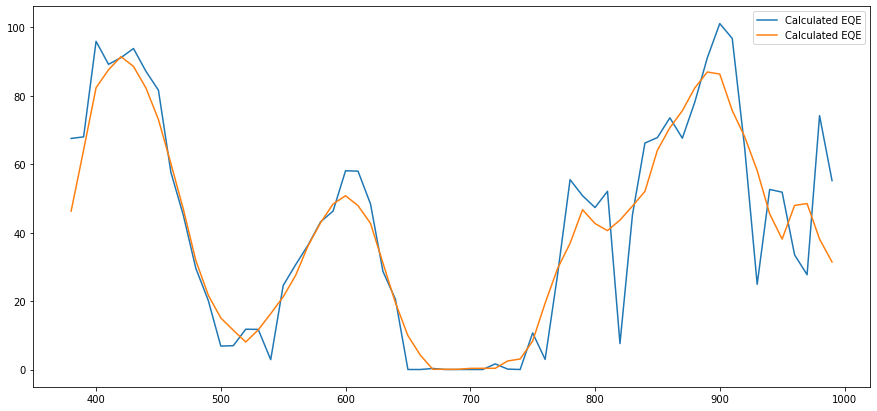

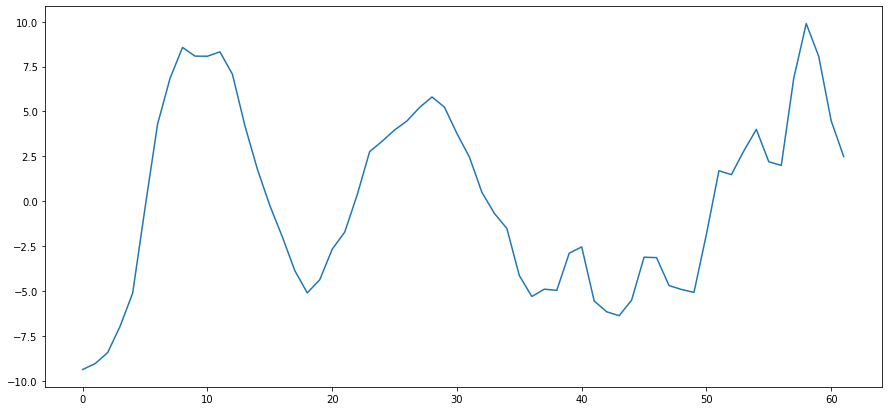

In [249]:
#COBYLA minimization with derivative constrains
def diff(EQE_solution,A,b):    
    AEQE_product = np.dot(A,EQE_solution)
    EQE_minimize = (AEQE_product[:]-b[:])**2
    EQE_diff_summ = np.sum(EQE_minimize[:])
    # if EQE_diff_summ <=10:
    #     print (EQE_diff_summ)
    return EQE_diff_summ

def constr1(EQE_solution,A,offset):
    #AEQE_product = np.dot(A,EQE_solution)
    #EQE_fit = numpy.polynomial.polynomial.Polynomial.fit(c_matrix_wl, EQE_solution, 10)(c_matrix_wl)
    EQE_fit = smooth(EQE_solution,10)
    return -np.gradient(EQE_fit)+offset

def constr2(EQE_solution,A,offset):
    #EQE_fit = numpy.polynomial.polynomial.Polynomial.fit(c_matrix_wl, EQE_solution, 10)(c_matrix_wl)
    EQE_fit = smooth(EQE_solution,10)
    return np.gradient(EQE_fit)+offset

def constr3(EQE_solution):
    return(EQE_solution)

ofst = 10
con1 = {'type': 'ineq', 'fun': constr1, 'args': (c_matrix, ofst)}
con2 = {'type': 'ineq', 'fun': constr2, 'args': (c_matrix, ofst)}
con3 = {'type': 'ineq', 'fun': constr3}
EQE_0 = 60*np.ones(len(c_matrix[0,:]))
EQE_0[-8:] = 0
#EQE_0 = EQE_interpolation(c_matrix_wl)

res = optimize.minimize(diff, EQE_0, method='cobyla', options={'maxiter':10000}, constraints=(con1, con3), args = (c_matrix, 15*measure_Jsc), tol = 0.0001)
print(res)

fig, ax = plt.subplots(figsize=(15,7))
#ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.plot(c_matrix_wl, res.x, label = 'Calculated EQE')
ax.plot(c_matrix_wl, smooth(res.x,5), label = 'Calculated EQE')
#ax.plot(c_matrix_wl, numpy.polynomial.polynomial.Polynomial.fit(c_matrix_wl, res.x, 20)(c_matrix_wl), label = 'fit_EQE')
plt.legend()
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(constr1(res.x,c_matrix,0))

In [263]:
#Now we will make the macro_c_matrix and macro_measure_jsc which are the interpolations in the vertical directions for having more information. 

equations_min = max(min(spectra_matrix_cutwl[:]),min(measure_divwl[:]))[0]
equations_max = min(max(measure_divwl[:]), max(spectra_matrix_cutwl))[0]
print(equations_min, equations_max)
total_equations = 1000
macro_c_matrix = np.zeros((total_equations, len(c_matrix[0,:])))

for j in range(len(macro_c_matrix[0,:])):
    actual_wl_interpolation = interpolate.interp1d(spectra_matrix_cutwl[:,0], c_matrix[:,j], kind='linear')

    macro_c_matrix[:,j] = actual_wl_interpolation(np.linspace(equations_min, equations_max, total_equations))

macro_measure_Jsc_interpolation = interpolate.interp1d(measure_divwl, measure_Jsc, kind='linear')
#macro_measure_Jsc_interpolation = interpolate.interp1d(measure_divwl, Jsc_calculated, kind='cubic')
macro_measure_Jsc = macro_measure_Jsc_interpolation(np.linspace(equations_min, equations_max, total_equations))

360.4151 759.8032


IndexError: index 1500 is out of bounds for axis 0 with size 1000

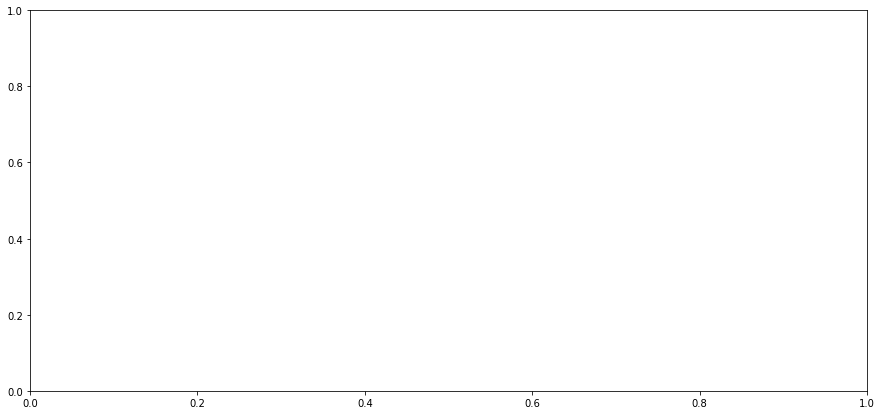

In [262]:
fig, ax = plt.subplots(figsize=(15,7))
for j in range(1500,1501):
    
    #ax.plot(spectra_matrix_wls, spectra_matrix[j,:], label=str(spectra_matrix_cutwl[j])+str(spectra_matrix_cutwl_ideal[j]))
    ax.plot(c_matrix_wl, macro_c_matrix[j,:])#, label=str(j))#c_matrix_wl,
    #ax.legend()

ValueError: x and y must have same first dimension, but have shapes (600,) and (120,)

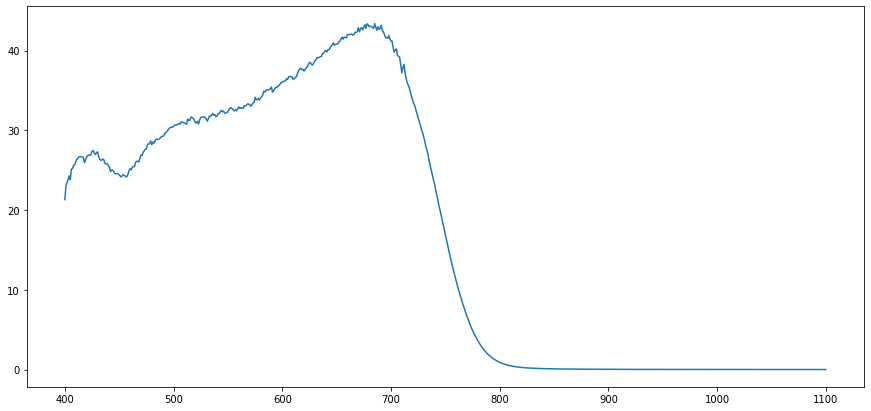

In [261]:
#Here we do the calculations with the linear equations system

EQE_linearsolution, residuals, rank, s = np.linalg.lstsq(macro_c_matrix, 20*macro_measure_Jsc, rcond=None)
#EQE_linearsolution = linalg.solve(c_matrix, measure_Jsc)
fig, ax = plt.subplots(figsize=(15,7))
#print(EQE_linearsolution)
#ax.plot(sf.Extract_Column(Active_layer_1.EQE_curve, 0), 1*np.array(sf.Extract_Column(Active_layer_1.EQE_curve, 1)), label = 'Real EQE')
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.plot(c_matrix_wl, EQE_linearsolution, label = 'Calculated EQE')
ax.legend()
#plt.ylim(0,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)


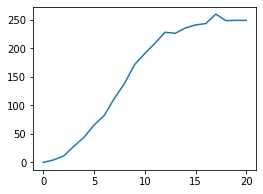

In [305]:
#Now we take a measured EQE and we calculate the theoretical Jsc corresponding to each row of the c_matrix

Jsc_correction_factor = 1
real_EQE= np.loadtxt('MCV.210602.OT2.labona.L.04.txt', skiprows=1)
EQE_interpolation = interpolate.interp1d(real_EQE[:,0], real_EQE[:,1], kind='cubic')
Jsc_calculated = np.zeros(len(c_matrix[:,0]))

for j in range(len(c_matrix[:,0])):
    spectra_interpolation = interpolate.interp1d(spectra_data[:,0,j], spectra_data[:,1,j], kind='cubic')
    Jsc_summ = 0
    for i in range(len(c_matrix[0,:])):
        actual_wl = c_matrix_wl[i]
        Jsc_summ = Jsc_summ + Jsc_correction_factor*EQE_interpolation(actual_wl)*c_matrix[j,i]

    Jsc_calculated[j] = Jsc_summ + np.random.randint(-1, 1)*5*Jsc_summ/100

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(Jsc_calculated[:])

In [27]:
#Here we try to make a polynomial fit of the Jss with noise, to see if it is possible to recover better the real signal for a better resolution
Jsc_calculated_fit = numpy.polynomial.polynomial.Polynomial.fit(measure_divwl, Jsc_calculated, 10)(measure_divwl)

fig, ax = plt.subplots(figsize=(20,15))
ax.plot(measure_divwl, Jsc_calculated_fit, label='Fit')
ax.plot(measure_divwl, Jsc_calculated, label='Calculated')
plt.legend()

NameError: name 'Jsc_calculated' is not defined

In [317]:
def EQE_minimize(EQE_solution,A,b):    
    AEQE_product = np.dot(A,EQE_solution)
    EQE_minimize = AEQE_product[:]-b[:]
    #EQE_diff_summ = np.sum(EQE_minimize[:])
    # if EQE_diff_summ <=10:
    #     print (EQE_diff_summ)
    return EQE_minimize
    
#EQE_calc_linearsol, residuals, rank, s = np.linalg.lstsq(c_matrix, Jsc_calculated_fit(measure_divwl), rcond=None)#_fit(measure_divwl)
#EQE_calc_linearsol = optimize.lsq_linear(c_matrix,Jsc_calculated, bounds=(0,100), lsq_solver='exact', tol=0.001, method='trf', max_iter=200).x
EQE_0 = 0*np.ones(len(c_matrix[0,:]))
EQE_calc_linearsol = optimize.least_squares(EQE_minimize, EQE_0, method='lm', args=(c_matrix, Jsc_calculated_fit)).x

#EQE_linearsolution = linalg.solve(c_matrix, measure_Jsc)
fig, ax = plt.subplots(figsize=(15,7))
#print(EQE_linearsolution)
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.plot(c_matrix_wl, EQE_calc_linearsol, label = 'Calculated EQE')
#ax.plot(c_matrix_wl, smooth(EQE_calc_linearsol, 40), label = 'smooth EQE')
#ax.plot(c_matrix_wl, smooth(smooth(EQE_calc_linearsol, 40), 60), label = 'smoothx2 EQE')
#ax.plot(spectra_data[:,0,20],spectra_data[:,1,99])
ax.legend()
plt.ylim(0,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)


ValueError: Method 'lm' doesn't work when the number of residuals is less than the number of variables.

In [692]:
EQE_calc_linearsol_interp = interpolate.interp1d(c_matrix_wl, EQE_calc_linearsol, kind='linear')
real_EQE_interp = interpolate.interp1d(real_EQE[:,0], real_EQE[:,1], kind='linear')
noise_function = EQE_calc_linearsol_interp(c_matrix_wl) - real_EQE_interp(c_matrix_wl)

In [ ]:
#Here we will try to solve the same system with the same method as before but shuffling the equations. Maybe this can be a solution!!
Jsc_calculated_reshape = np.expand_dims(Jsc_calculated, axis=1)
Jsc_Cmatrix = np.append(Jsc_calculated_reshape, c_matrix, axis=1)
#Jsc_calculated_reshape = np.expand_dims(macro_measure_Jsc, axis=1)
#Jsc_Cmatrix = np.append(Jsc_calculated_reshape, macro_c_matrix, axis=1)
np.random.shuffle(Jsc_Cmatrix)

# EQE_linearsolution, residuals, rank, s = np.linalg.lstsq(Jsc_Cmatrix[:,1:], Jsc_Cmatrix[:,0], rcond=None)
# EQE_linearsolution_nnls, rnorm = optimize.nnls(Jsc_Cmatrix[:,1:], Jsc_Cmatrix[:,0])
# EQE_linearsolution_lsqlinear = optimize.lsq_linear(Jsc_Cmatrix[:,1:], Jsc_Cmatrix[:,0], bounds=(0,100))

EQE_linearsolution, residuals, rank, s = np.linalg.lstsq(c_matrix, Jsc_calculated, rcond=None)
EQE_linearsolution_nnls, rnorm = optimize.nnls(c_matrix, Jsc_calculated)
EQE_linearsolution_lsqlinear = optimize.lsq_linear(c_matrix, Jsc_calculated, bounds=(0,100), method='trf')

# EQE_linearsolution, residuals, rank, s = np.linalg.lstsq(macro_c_matrix, macro_measure_Jsc, rcond=None)
# EQE_linearsolution_nnls, rnorm = optimize.nnls(macro_c_matrix, macro_measure_Jsc)
# EQE_linearsolution_lsqlinear = optimize.lsq_linear(macro_c_matrix, macro_measure_Jsc, bounds=(0,100))



#EQE_linearsolution = linalg.solve(c_matrix, measure_Jsc)
fig, ax = plt.subplots(figsize=(15,7))
#print(EQE_linearsolution)
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.plot(c_matrix_wl, EQE_linearsolution, label = 'Calculated EQE np.lstsq')
#ax.plot(c_matrix_wl, EQE_linearsolution_nnls, label = 'Calculated EQE nnl')
ax.plot(c_matrix_wl, EQE_linearsolution_lsqlinear.x, label = 'Calculated EQE lsq_linear')#, linestyle=(0, (1, 5)))
#ax.plot(spectra_data[:,0,20],spectra_data[:,1,99])
ax.legend()
plt.ylim(0,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)


In [ ]:
, Jsc_Cmatrix[:,0])

#EQE_linearsolution= optimize.lsq_linear(Jsc_Cmatrix[:,1:], Jsc_Cmatrix[:,0], bounds=(0,100))
#EQE_linearsolution = linalg.solve(c_matrix, measure_Jsc)
fig, ax = plt.subplots(figsize=(15,7))
#print(EQE_linearsolution)
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.plot(c_matrix_wl, EQE_linearsolution, label = 'Calculated EQE')
#ax.plot(spectra_data[:,0,20],spectra_data[:,1,99])
ax.legend()
#plt.ylim(-100,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)


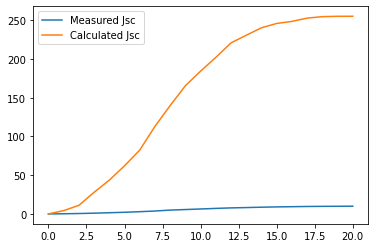

In [1170]:
fig, ax = plt.subplots()
ax.plot(measure_Jsc[:], label= 'Measured Jsc')
ax.plot(Jsc_calculated[:], label='Calculated Jsc')
plt.legend()
#plt.ylim(0,12)

<ipython-input-43-12ec475ede6e>:26: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(100*EQE_rest[:]/(25*measure_Jsc[:]))


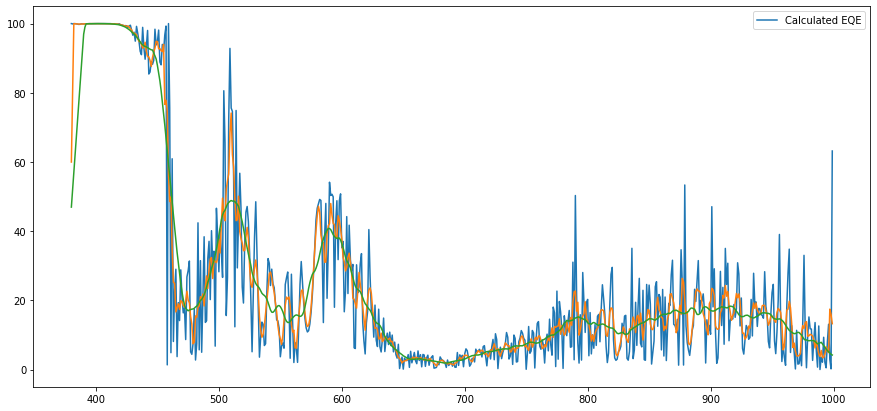

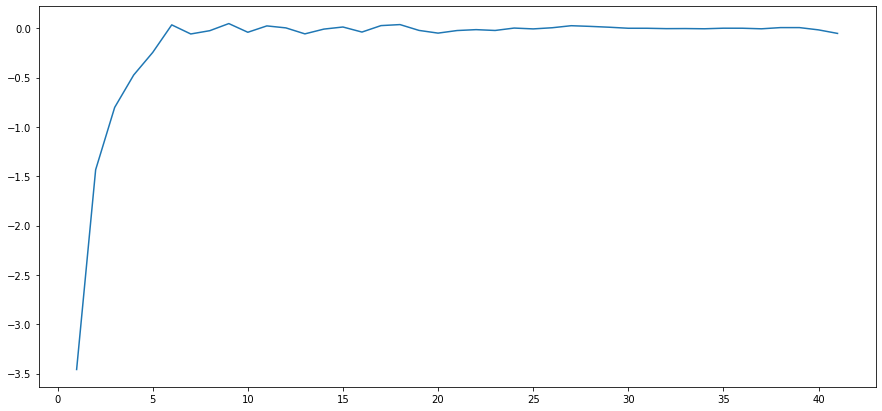

In [43]:
#Here we do the calculations with the linear equations system

#EQE_linearsolution, residuals, rank, s = np.linalg.lstsq(c_matrix, measure_Jsc, rcond=None)
#EQE_linearsolution_all = optimize.lsq_linear(c_matrix,25*measure_Jsc, bounds=(0,100), lsq_solver='exact', tol=0.001, method='trf', max_iter=200)
EQE_linearsolution_all = optimize.lsq_linear(c_matrix_vderivative,np.gradient(measure_Jsc), bounds=(0,100), lsq_solver='exact', tol=0.001, method='trf', max_iter=20000)
EQE_linearsolution = EQE_linearsolution_all.x
EQE_rest = EQE_linearsolution_all.fun

#EQE_linearsolution = sparse.linalg.bicg(macro_c_matrix, 6*macro_measure_Jsc)

#EQE_linearsolution = linalg.solve(c_matrix, measure_Jsc)
fig, ax = plt.subplots(figsize=(15,7))
#print(EQE_linearsolution)
#ax.plot(sf.Extract_Column(Active_layer_1.EQE_curve, 0), 1*np.array(sf.Extract_Column(Active_layer_1.EQE_curve, 1)), label = 'Real EQE')
#ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.plot(c_matrix_wl, EQE_linearsolution, label = 'Calculated EQE')#-0.5*noise_function
ax.plot(c_matrix_wl, smooth(EQE_linearsolution,5))
ax.plot(c_matrix_wl, smooth(smooth(EQE_linearsolution, 5),20))
ax.legend()
#print(EQE_linearsolution.fun)
#plt.ylim(0,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(100*EQE_rest[:]/(25*measure_Jsc[:]))
#plt.ylim(-10,10)

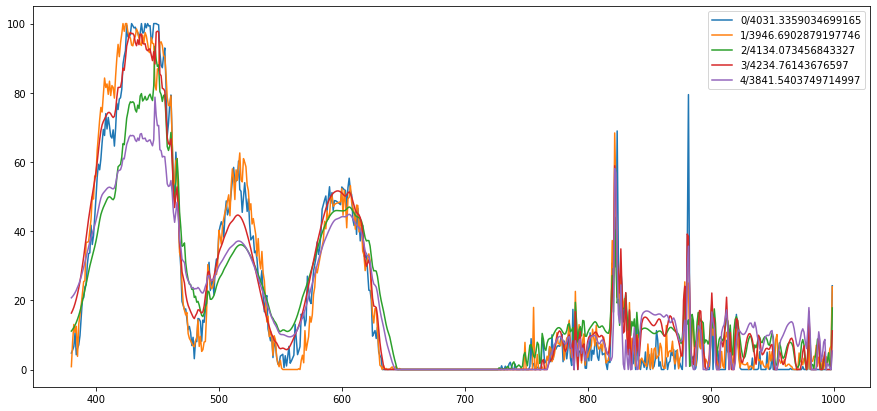

In [31]:
#Now we do the resolution of the measured EQE with the least squares minimum
def EQE_minimize(EQE_solution,A,b):    
    AEQE_product = np.dot(A,EQE_solution)
    EQE_minimize = abs(AEQE_product[:]-b[:])
    EQE_diff_summ = np.sum(EQE_minimize[:])
    # if EQE_diff_summ <=10:
    #     print (EQE_diff_summ)

    return np.sum(EQE_diff_summ)

#c_matrix[:,45:] = 0

bnds = optimize.Bounds(0, 100)

fig, ax = plt.subplots(figsize=(15,7))
EQE_0 = np.zeros((len(c_matrix_wl)))
EQE_minimize_coef = np.zeros((5))
EQE_minimize_solution_all = np.zeros((len(c_matrix_wl),len(EQE_minimize_coef)))
for j in range(len(EQE_minimize_coef)):
    for i in range(len(EQE_0)):
        EQE_0[i] = 5*j

    minimize_solution = optimize.minimize(EQE_minimize, EQE_0[:], args = (c_matrix_vderivative, np.gradient(measure_Jsc)),bounds=bnds, )   #0.55*measure_Jsc #Jsc_calculated (c_matrix, 5*measure_Jsc)
    #minimize_solution = optimize.least_squares(EQE_minimize, EQE_0[:], args = (macro_c_matrix, 0.6*macro_measure_Jsc),bounds=(0,100))             
    EQE_minimize_solution_all[:,j]= minimize_solution.x
    EQE_minimize_coef[j] = EQE_minimize(EQE_minimize_solution_all[:,j],c_matrix,measure_Jsc)
    ax.plot(c_matrix_wl, 1*EQE_minimize_solution_all[:,j], label = str(j)+'/'+str(EQE_minimize_coef[j]))


#print(EQE_approximation, EQE_aproximation[:,0])
#EQE_aproximation[:] = 30*EQE_aproximation[:]


#real_EQE= np.loadtxt('MCV.210602.OT2.labona.L.04.txt', skiprows=1)

#EQE_approximation[-1,0] = 350
#ax.plot(c_matrix_wl, 300*EQE_minimize_solution, label = 'Calculated EQE')
#ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
j=-1
#ax.plot(c_matrix_wl,50*c_matrix[j,:], label=str(j))
ax.legend()
#plt.ylim(0,100)
#plt.xlim(350,740)


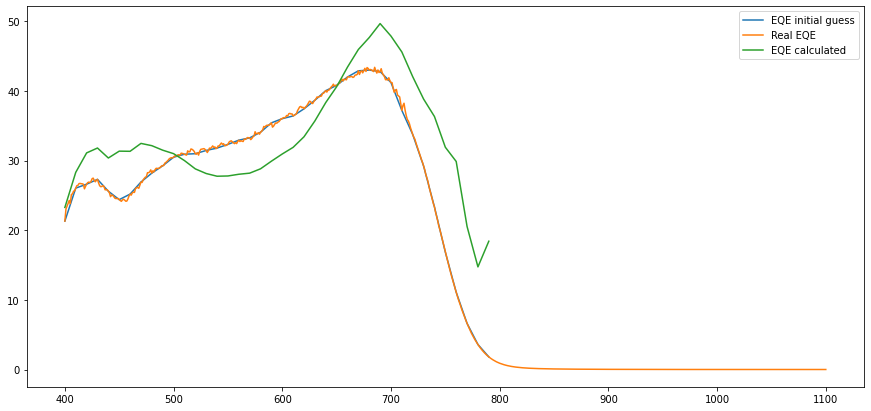

In [418]:
#now, trying the real EQE as initial guess:
fig, ax = plt.subplots(figsize=(15,7))

real_EQE_interpolation = interpolate.interp1d(real_EQE[:,0], real_EQE[:,1], kind='cubic')
EQE_0 = 1*real_EQE_interpolation(c_matrix_wl)
ax.plot(c_matrix_wl, EQE_0, label='EQE initial guess')

bnds = optimize.Bounds(0, 100)
#minimize_solution = optimize.minimize(EQE_minimize, EQE_0[:], args = (c_matrix, 0.58*measure_Jsc),bounds=bnds, )   #0.58*measure_Jsc
minimize_solution = optimize.least_squares(EQE_minimize, EQE_0[:], args = (c_matrix, 5*measure_Jsc),bounds=(0,100))             
EQE_minimize_solution= minimize_solution.x
EQE_minimize_coef = EQE_minimize(EQE_minimize_solution,c_matrix,measure_Jsc)
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.plot(c_matrix_wl, 1*EQE_minimize_solution,label='EQE calculated')
plt.legend()
